In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

Using TensorFlow backend.


In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
print("train shape:", train.shape, "test.shape:", test.shape)

train shape: (200000, 202) test.shape: (200000, 201)


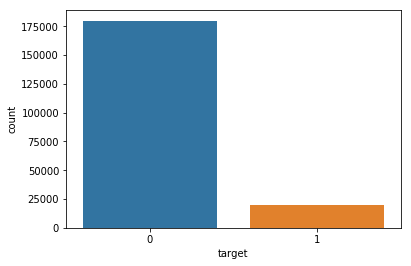

In [3]:
sns.countplot(train['target'])

In [4]:
total1 = train["target"].value_counts()[1]
print("There are {} target values with 1, is about {}% of total data".format(total1, 100 * total1/train.shape[0]))

There are 20098 target values with 1, is about 10.049% of total data


In [5]:
train0 = train.loc[train['target'] == 0]
train1 = train.loc[train['target'] == 1]
print(train0.shape, train1.shape)
splitNum = 2
t0PerSplit = train0.shape[0] // splitNum
print(t0PerSplit)
splits = []
for i in range(splitNum-1):
    splits.append(pd.concat([train0[i*t0PerSplit:(i+1)*t0PerSplit], train1]).sample(frac=1))
    print(splits[i].shape)
splits.append(pd.concat([train0[(splitNum-1)*t0PerSplit:], train1]).sample(frac=1))
print(splits[splitNum-1].shape)
splits[splitNum-1].iloc[:,1].values[:100]

(179902, 202) (20098, 202)
89951
(110049, 202)
(110049, 202)


array([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [6]:
features = train.columns.values[2:202]
scaler = StandardScaler()
x_test = scaler.fit_transform(test[features])

In [7]:
X_test = x_test.reshape(200000,20,10,1)
predictions = np.zeros(len(X_test)) 
print(X_test.shape, predictions.shape)
for split_ in range(splitNum):
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)
    #train_s = splits[split_][features]
    train_s =  scaler.transform(splits[split_][features])
    target_s = splits[split_]["target"]
    print(train_s.shape, target_s.shape)
    prediction = np.zeros(len(test))
    oof = np.zeros(len(train_s))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_s, target_s)):
        X_train, y_train = train_s[trn_idx], target_s.iloc[trn_idx]
        X_train = X_train.reshape(trn_idx.shape[0], 20, 10, 1)
        X_valid, y_valid = train_s[val_idx], target_s.iloc[val_idx]
        X_valid = X_valid.reshape(val_idx.shape[0], 20, 10, 1)
        print("Split:", split_,  "Fold:",fold_, trn_idx.shape, val_idx.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
        #create model
        model = Sequential()
        #add model layers
        model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(20,10,1)))
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        #compile model using accuracy to measure model performance
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        #train the model
        model.fit(X_train, y_train, batch_size=100, validation_data=(X_valid, y_valid), epochs=10)
    
        y_pred = model.predict_classes(X_valid)
        oof = model.predict_classes(X_valid)
        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    
        # Accuracy: Overall, how often is the classifier correct?  (tp+tn) / (tn+fp+fn+tp)
        # Precision score, When it predicts yes, how often is it correct?  tp/(fp + tp)
        # Specificity, True Negative Rate: When it's actually no, how often does it predict no? tn/(tn+fp)
        # Recall score, or Sensitivity, True positive rate, When it's actually yes, how often does it predict yes? tp/(fn+tp)
    
        print("precision_score:", tp/(fp + tp), "specificity_score:", tn/(tn+fp), "recall_score:", tp/(fn+tp))
        # F1 score
        print("f1_score", f1_score(y_valid,y_pred))
        print("CV score: {:<8.5f}".format(roc_auc_score(y_valid, oof)))
        # Cohen's kappa score
        #cohen_kappa_score(y_valid, y_pred)
    
        prediction += model.predict_proba(X_test)[:,0] / folds.n_splits 
        #print("CV score: {:<8.5f}".format(roc_auc_score(target_s, oof)))
    predictions += prediction / splitNum   

(200000, 20, 10, 1) (200000,)
(110049, 200) (110049,)
Split: 0 Fold: 0 (99043,) (11006,) (99043, 20, 10, 1) (99043,) (11006, 20, 10, 1) (11006,)
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 8, 64)         640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 6, 32)         18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3073      
Total params: 22,177
Trainable params: 22,177
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train

In [8]:
print(predictions.shape)
predictions[:50]

(200000,)


array([0.37978114, 0.27527453, 0.35037637, 0.23795272, 0.05126813,
       0.00269488, 0.00706564, 0.27345482, 0.00482056, 0.01269095,
       0.21768087, 0.07763978, 0.06152566, 0.03754044, 0.00621917,
       0.07086374, 0.56385864, 0.03308931, 0.28205256, 0.01566839,
       0.39480001, 0.07942291, 0.01467016, 0.0385584 , 0.02200476,
       0.10462904, 0.10743308, 0.01515918, 0.28797356, 0.22711146,
       0.08697483, 0.12591527, 0.52236824, 0.6392502 , 0.01246845,
       0.03958668, 0.01323744, 0.02500872, 0.0099451 , 0.01265371,
       0.0305037 , 0.00729581, 0.01152961, 0.00728576, 0.04437138,
       0.04130413, 0.01681336, 0.08010537, 0.01915049, 0.04646903])

In [9]:
sub = pd.DataFrame() 
sub["ID_code"] = test["ID_code"] 
sub["target"] = predictions
sub.to_csv("submission-cnn-ksplit.csv", index=False)